In [1]:
import os
import torch
from tqdm import tqdm
import plotly.express as px
import pickle

torch.set_grad_enabled(False)

In [2]:
# For the most part I'll try to import functions and classes near where they are used
# to make it clear where they come from.

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

Device: cuda


In [3]:
from datasets import load_dataset
from transformer_lens import HookedTransformer
from sae_lens import SAE

model = HookedTransformer.from_pretrained("gpt2-small", device=device)

# the cfg dict is returned alongside the SAE since it may contain useful information for analysing the SAE (eg: instantiating an activation store)
# Note that this is not the same as the SAEs config dict, rather it is whatever was in the HF repo, from which we can extract the SAE config dict
# We also return the feature sparsities which are stored in HF for convenience.
sae, cfg_dict, sparsity = SAE.from_pretrained(
    release="gpt2-small-res-jb",  # see other options in sae_lens/pretrained_saes.yaml
    sae_id="blocks.8.hook_resid_pre",  # won't always be a hook point
    device=device,
)

Loaded pretrained model gpt2-small into HookedTransformer


/opt/conda/lib/python3.10/site-packages/sae_lens/sae.py:136: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


In [4]:
# def zero_abl_hook(activation, hook):
#     return torch.zeros_like(activation)

def direct(activation, hook):
    return activation

def clamping(activation, hook):
    encoded = sae.encode(activation)

    # The activations are now stored in intermediate_outputs
    # Modify activations
    # print(encoded.shape)
    # print(encoded[:, :, torch.argmax(encoded)])
    # encoded[:, :, :] = 0.0
    encoded[0, :, 3] = 50.0

    sae_out = sae.decode(encoded)

    return sae_out

In [5]:
example_prompt = "<|endoftext|>"

input_tokens = model.to_tokens(example_prompt, prepend_bos=True)

logits = model(input_tokens)
probs = logits.softmax(dim=-1)

index = len(input_tokens[0])
token_probs = probs[:, index - 1]
sorted_token_probs, sorted_token_positions = token_probs.sort(descending=True)

for i in range(10):
    print(
        f"Top {i}th token. Logit: {logits[0, index-1, sorted_token_positions[0, i]].item():5.2f} Prob: {sorted_token_probs[0, i].item():6.2%} Token: |{model.to_string(sorted_token_positions[0, i])}|"
    )

Top 0th token. Logit: 18.28 Prob:  7.68% Token: |The|
Top 1th token. Logit: 17.47 Prob:  3.40% Token: |A|
Top 2th token. Logit: 16.96 Prob:  2.04% Token: |This|
Top 3th token. Logit: 16.85 Prob:  1.84% Token: |In|
Top 4th token. Logit: 16.71 Prob:  1.60% Token: |I|
Top 5th token. Logit: 16.67 Prob:  1.54% Token: |"|
Top 6th token. Logit: 16.62 Prob:  1.46% Token: |It|
Top 7th token. Logit: 16.26 Prob:  1.02% Token: |We|
Top 8th token. Logit: 16.06 Prob:  0.83% Token: |As|
Top 9th token. Logit: 15.99 Prob:  0.78% Token: |If|


In [6]:
example_prompt = "The"

input_tokens = model.to_tokens(example_prompt, prepend_bos=True)

logits = model(input_tokens)
probs = logits.softmax(dim=-1)

index = len(input_tokens[0])
token_probs = probs[:, index - 1]
sorted_token_probs, sorted_token_positions = token_probs.sort(descending=True)

for i in range(10):
    print(
        f"Top {i}th token. Logit: {logits[0, index-1, sorted_token_positions[0, i]].item():5.2f} Prob: {sorted_token_probs[0, i].item():6.2%} Token: |{model.to_string(sorted_token_positions[0, i])}|"
    )

Top 0th token. Logit:  9.30 Prob:  1.00% Token: | first|
Top 1th token. Logit:  9.16 Prob:  0.87% Token: | U|
Top 2th token. Logit:  9.09 Prob:  0.81% Token: | following|
Top 3th token. Logit:  8.84 Prob:  0.63% Token: | United|
Top 4th token. Logit:  8.69 Prob:  0.55% Token: | US|
Top 5th token. Logit:  8.65 Prob:  0.52% Token: | New|
Top 6th token. Logit:  8.61 Prob:  0.50% Token: | latest|
Top 7th token. Logit:  8.58 Prob:  0.49% Token: | world|
Top 8th token. Logit:  8.56 Prob:  0.48% Token: | most|
Top 9th token. Logit:  8.51 Prob:  0.46% Token: | new|


In [9]:
example_prompt = "The world is revolving"

def act_analysis(activation, hook):
    print(activation.shape)
    encoded = sae.encode(activation)
    print(encoded.shape)
    return activation

with model.hooks(
    fwd_hooks=[(sae.cfg.hook_name, act_analysis)],
):
    
    input_tokens = model.to_tokens(example_prompt, prepend_bos=True)

    logits = model(input_tokens)
    probs = logits.softmax(dim=-1)

    index = len(input_tokens[0])
    print(index)
    token_probs = probs[:, index - 1]
    sorted_token_probs, sorted_token_positions = token_probs.sort(descending=True)

    # for i in range(10):
    #     print(
    #         f"Top {i}th token. Logit: {logits[0, index-1, sorted_token_positions[0, i]].item():5.2f} Prob: {sorted_token_probs[0, i].item():6.2%} Token: |{model.to_string(sorted_token_positions[0, i])}|"
    #     )

    generated_tokens = model.generate(input_tokens, max_new_tokens=100, do_sample=True, use_past_kv_cache=False)

    generated_tokens = model.tokenizer.decode(generated_tokens[0])
    print(generated_tokens)

torch.Size([1, 5, 768])
torch.Size([1, 5, 24576])
5


  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([1, 5, 768])
torch.Size([1, 5, 24576])
torch.Size([1, 6, 768])
torch.Size([1, 6, 24576])
torch.Size([1, 7, 768])
torch.Size([1, 7, 24576])
torch.Size([1, 8, 768])
torch.Size([1, 8, 24576])
torch.Size([1, 9, 768])
torch.Size([1, 9, 24576])
torch.Size([1, 10, 768])
torch.Size([1, 10, 24576])
torch.Size([1, 11, 768])
torch.Size([1, 11, 24576])
torch.Size([1, 12, 768])
torch.Size([1, 12, 24576])
torch.Size([1, 13, 768])
torch.Size([1, 13, 24576])
torch.Size([1, 14, 768])
torch.Size([1, 14, 24576])
torch.Size([1, 15, 768])
torch.Size([1, 15, 24576])
torch.Size([1, 16, 768])
torch.Size([1, 16, 24576])
torch.Size([1, 17, 768])
torch.Size([1, 17, 24576])
torch.Size([1, 18, 768])
torch.Size([1, 18, 24576])
torch.Size([1, 19, 768])
torch.Size([1, 19, 24576])
torch.Size([1, 20, 768])
torch.Size([1, 20, 24576])
torch.Size([1, 21, 768])
torch.Size([1, 21, 24576])
torch.Size([1, 22, 768])
torch.Size([1, 22, 24576])
torch.Size([1, 23, 768])
torch.Size([1, 23, 24576])
torch.Size([1, 24, 768

In [10]:
import torch.nn.functional as F

def get_embedding(word):
    tokens = model.to_tokens(word, prepend_bos=True)
    embedding = model.embed(tokens)
    _, cache = model.run_with_cache(tokens)
    encoded = sae.encode(cache[sae.cfg.hook_name])
    return embedding[:, -1, :], encoded[:, -1, :]

word1 = "apple"
word2 = "The apple"

embedding1, sae_embedding1 = get_embedding(word1)
embedding2, sae_embedding2 = get_embedding(word2)

print(embedding1.shape, sae_embedding1.shape)
print(embedding2.shape, sae_embedding2.shape)

# Compute cosine similarity
cos_sim = F.cosine_similarity(embedding1, embedding2, dim=-1)
print(f"Cosine similarity between '{word1}' and '{word2}': {cos_sim.item()}")

sae_cos_sim = F.cosine_similarity(sae_embedding1, sae_embedding2, dim=-1)
print(f"SAE Cosine similarity between '{word1}' and '{word2}': {sae_cos_sim.item()}")

torch.Size([1, 768]) torch.Size([1, 24576])
torch.Size([1, 768]) torch.Size([1, 24576])
Cosine similarity between 'apple' and 'The apple': 0.5681918263435364
SAE Cosine similarity between 'apple' and 'The apple': 0.741217851638794


In [11]:
top_unigrams = []
top_bigrams = {}
top_trigrams = {}

# Unigrams
input_tokens = model.to_tokens("<|endoftext|>", prepend_bos=True)

logits = model(input_tokens)
probs = logits.softmax(dim=-1)

index = len(input_tokens[0])
token_probs = probs[:, index - 1]
sorted_token_probs, sorted_token_positions = token_probs.sort(descending=True)

for i in range(10):
    top_unigrams.append(model.to_string(sorted_token_positions[0, i]))

# Bigrams
for unigram in top_unigrams:
    input_tokens = model.to_tokens(f"{unigram}", prepend_bos=True)

    logits = model(input_tokens)
    probs = logits.softmax(dim=-1)

    index = len(input_tokens[0])
    token_probs = probs[:, index - 1]
    sorted_token_probs, sorted_token_positions = token_probs.sort(descending=True)

    top_bigrams[unigram] = []
    for i in range(10):
        top_bigrams[unigram].append(unigram + model.to_string(sorted_token_positions[0, i]))

print(top_bigrams)

# Trigrams
for unigram in top_bigrams:
    top_trigrams[unigram] = {}
    for bigram in top_bigrams[unigram]:
        input_tokens = model.to_tokens(f"{bigram}", prepend_bos=True)

        logits = model(input_tokens)
        probs = logits.softmax(dim=-1)

        index = len(input_tokens[0])
        token_probs = probs[:, index - 1]
        sorted_token_probs, sorted_token_positions = token_probs.sort(descending=True)

        top_trigrams[unigram][bigram] = []
        for i in range(10):
            top_trigrams[unigram][bigram].append(bigram + model.to_string(sorted_token_positions[0, i]))

print(top_trigrams)

{'The': ['The first', 'The U', 'The following', 'The United', 'The US', 'The New', 'The latest', 'The world', 'The most', 'The new'], 'A': ['A new', 'A man', 'A few', 'A group', 'A woman', 'A former', 'A couple', 'A lot', 'A federal', 'AUST'], 'This': ['This is', 'This article', 'This post', 'This week', 'This page', 'This story', 'This year', 'This was', 'This month', 'This site'], 'In': ['In the', 'In this', 'In a', 'In an', 'In his', 'In order', 'In addition', 'In my', 'In recent', 'In response'], 'I': ["I'm", "I've", 'I have', 'I am', 'I was', 'I don', 'I think', 'I had', 'I know', 'I can'], '"': ['"I', '"We', '"The', '"It', '"This', '"You', '"If', '"There', '"He', '"What'], 'It': ["It's", 'It is', 'It was', 'It has', 'It seems', 'It looks', 'It would', 'It took', 'It may', 'It appears'], 'We': ["We're", 'We are', "We've", 'We have', 'We all', 'We know', "We'll", 'We can', 'We will', 'We were'], 'As': ['As the', 'As a', 'As we', 'As you', 'As I', 'As part', 'As many', 'As an', 'As 

In [12]:
unigram_pairs = {}

for unigram1 in top_unigrams:
    for unigram2 in top_unigrams:
        embedding1, sae_embedding1 = get_embedding(unigram1)
        embedding2, sae_embedding2 = get_embedding(unigram2)
        unigram_pairs[(unigram1, unigram2)] = (embedding1, sae_embedding1, embedding2, sae_embedding2, F.cosine_similarity(embedding1, embedding2, dim=-1), F.cosine_similarity(sae_embedding1, sae_embedding2, dim=-1))

In [123]:
with open("/cris_lab/unigram_pairs.pkl", "wb") as f:
    pickle.dump({
        'unigram_pairs': unigram_pairs,
        'top_unigrams': top_unigrams
    }, f)

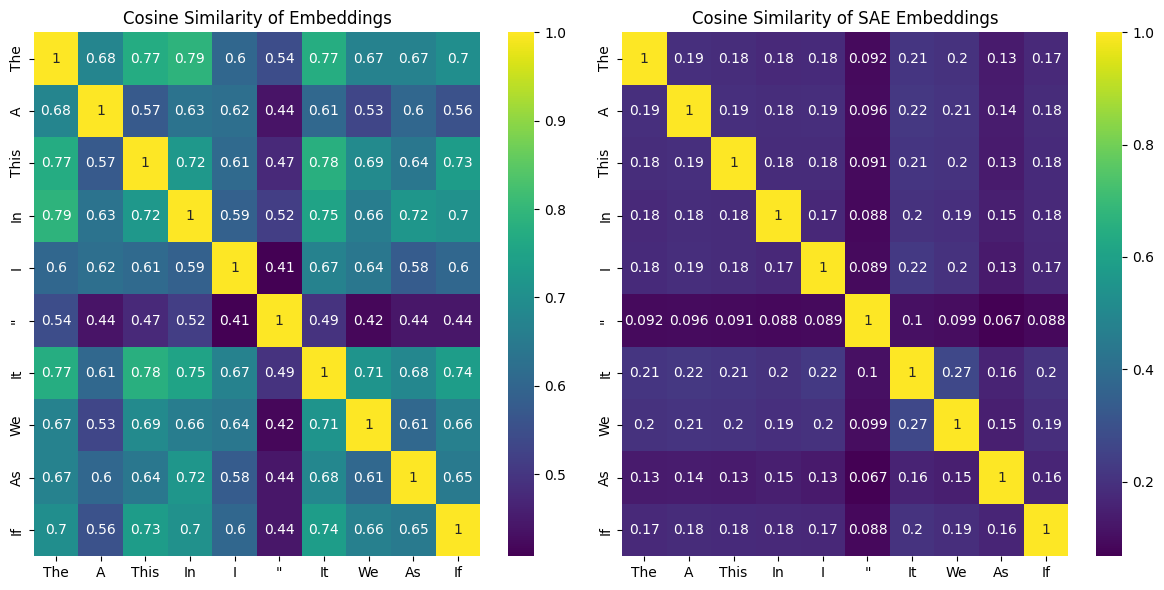

In [13]:
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

# Extract unigrams
unigrams = top_unigrams

# Initialize matrices for cosine similarities
cos_sim_matrix = np.zeros((len(unigrams), len(unigrams)))
sae_cos_sim_matrix = np.zeros((len(unigrams), len(unigrams)))

# Fill the matrices with cosine similarities
for i, unigram1 in enumerate(unigrams):
    for j, unigram2 in enumerate(unigrams):
        cos_sim_matrix[i, j] = unigram_pairs[(unigram1, unigram2)][4].item()
        sae_cos_sim_matrix[i, j] = unigram_pairs[(unigram1, unigram2)][5].item()

# Create heatmaps
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cos_sim_matrix, xticklabels=unigrams, yticklabels=unigrams, cmap='viridis', annot=True)
plt.title('Cosine Similarity of Embeddings')

plt.subplot(1, 2, 2)
sns.heatmap(sae_cos_sim_matrix, xticklabels=unigrams, yticklabels=unigrams, cmap='viridis', annot=True)
plt.title('Cosine Similarity of SAE Embeddings')

plt.tight_layout()
plt.show()

In [117]:
bigram_pairs = {}

all_bigrams = [bigram for bigrams in top_bigrams.values() for bigram in bigrams]

for bigram1 in all_bigrams:
    for bigram2 in all_bigrams:
        embedding1, sae_embedding1 = get_embedding(bigram1)
        embedding2, sae_embedding2 = get_embedding(bigram2)
        bigram_pairs[(bigram1, bigram2)] = (embedding1, sae_embedding1, embedding2, sae_embedding2, F.cosine_similarity(embedding1, embedding2, dim=-1), F.cosine_similarity(sae_embedding1, sae_embedding2, dim=-1))

In [124]:
with open('/cris_lab/bigram_pairs.pkl', 'wb') as f:
    pickle.dump({
        'bigram_pairs': bigram_pairs,
        'all_bigrams': all_bigrams
    }, f) 

In [17]:
with open('/cris_lab/bigram_pairs.pkl', 'rb') as f:
    data = pickle.load(f)
    bigram_pairs = data['bigram_pairs']
    all_bigrams = data['all_bigrams']

EOFError: Ran out of input

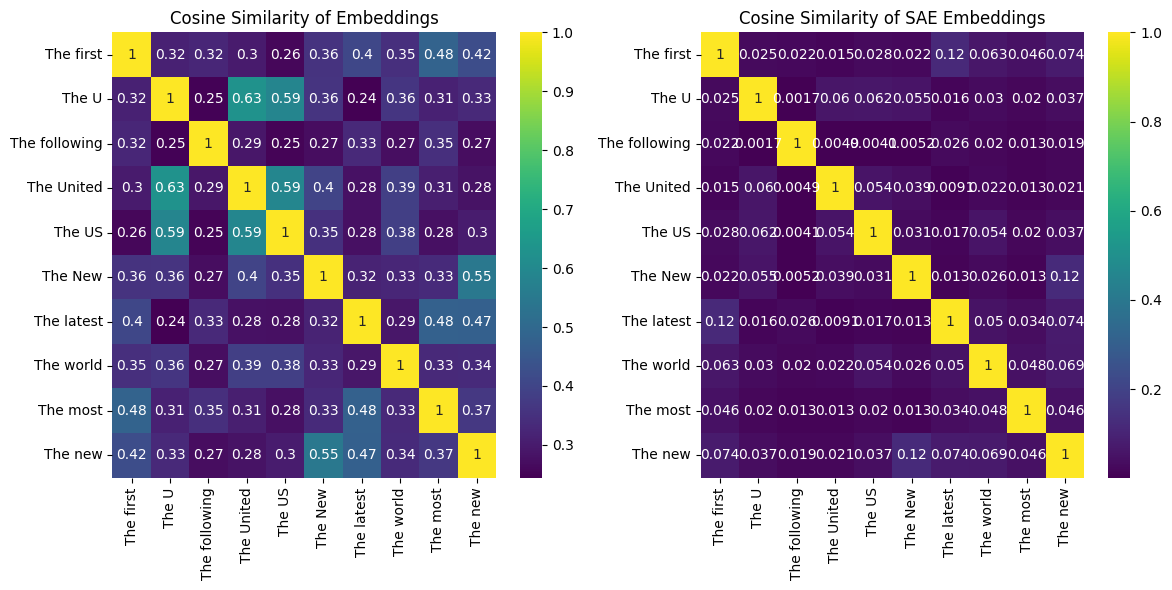

In [120]:
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

# Extract unigrams
bigrams = top_bigrams['The']

# Initialize matrices for cosine similarities
cos_sim_matrix = np.zeros((len(bigrams), len(bigrams)))
sae_cos_sim_matrix = np.zeros((len(bigrams), len(bigrams)))

# Fill the matrices with cosine similarities
for i, bigram1 in enumerate(bigrams):
    for j, bigram2 in enumerate(bigrams):
        cos_sim_matrix[i, j] = bigram_pairs[(bigram1, bigram2)][4].item()
        sae_cos_sim_matrix[i, j] = bigram_pairs[(bigram1, bigram2)][5].item()

# Create heatmaps
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cos_sim_matrix, xticklabels=bigrams, yticklabels=bigrams, cmap='viridis', annot=True)
plt.title('Cosine Similarity of Embeddings')

plt.subplot(1, 2, 2)
sns.heatmap(sae_cos_sim_matrix, xticklabels=bigrams, yticklabels=bigrams, cmap='viridis', annot=True)
plt.title('Cosine Similarity of SAE Embeddings')

plt.tight_layout()
plt.show()

In [ ]:
trigram_pairs = {}

all_trigrams = [trigram for trigrams in top_trigrams.values() for trigram in trigrams]

for trigram1 in all_trigrams:
    for trigram2 in all_trigrams:
        embedding1, sae_embedding1 = get_embedding(trigram1)
        embedding2, sae_embedding2 = get_embedding(trigram2)
        trigram_pairs[(trigram1, trigram2)] = (embedding1, sae_embedding1, embedding2, sae_embedding2, F.cosine_similarity(embedding1, embedding2, dim=-1), F.cosine_similarity(sae_embedding1, sae_embedding2, dim=-1))